In [11]:
#@title 0) Imports / config (deterministic & version print)
import os, sys, json, math, random, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

# ---- Reproducibility
os.environ["PYTHONHASHSEED"] = "0"
random.seed(42); np.random.seed(42)

# ---- Plot defaults
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True

# ---- Sanity print
import numpy, pandas, sklearn, matplotlib
print("VERSIONS:",
      "numpy", numpy.__version__, "| pandas", pandas.__version__,
      "| sklearn", sklearn.__version__, "| matplotlib", matplotlib.__version__)

VERSIONS: numpy 2.0.2 | pandas 2.2.2 | sklearn 1.6.1 | matplotlib 3.9.2


In [12]:
#@title 1) Upload your CSV (schema validated)
from google.colab import files

uploaded = files.upload()  # Pick "Assessment 2 - MMM Weekly.csv"
csv_path = list(uploaded.keys())[0]
df = pd.read_csv(csv_path)

# Expected schema
expected = {
    "week","facebook_spend","google_spend","tiktok_spend","instagram_spend","snapchat_spend",
    "social_followers","average_price","promotions","emails_send","sms_send","revenue"
}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {sorted(missing)}\n"
                     f"Found: {sorted(df.columns.tolist())}")

# Basic prep
df["week"] = pd.to_datetime(df["week"], errors="coerce")
df = df.sort_values("week").reset_index(drop=True)

print("Rows:", len(df), "| Range:", df["week"].min(), "→", df["week"].max())
display(df.head(5))

Saving Assessment 2 - MMM Weekly.csv to Assessment 2 - MMM Weekly (1).csv
Rows: 104 | Range: 2023-09-17 00:00:00 → 2025-09-07 00:00:00


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [13]:
#@title 2) Helpers (date features, adstock, metrics) + Parameters

# ---- Parameters (editable)
HOLDOUT_PCT = 0.20  #@param {type:"number"}
ADSTOCK_LAMBDA_GRID = [0.3, 0.5, 0.6, 0.7, 0.9]  #@param

# ---- Columns
target_col   = "revenue"
mediator_col = "google_spend"
social_cols  = ["facebook_spend","tiktok_spend","instagram_spend","snapchat_spend"]
controls     = ["social_followers","emails_send","sms_send"]
price_col    = "average_price"
promo_col    = "promotions"

class DateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="week"): self.date_col = date_col
    def fit(self, X, y=None): return self
    def transform(self, X):
        xx = X.copy()
        xx[self.date_col] = pd.to_datetime(xx[self.date_col], errors="coerce")
        xx["year"] = xx[self.date_col].dt.year
        xx["weekofyear"] = xx[self.date_col].dt.isocalendar().week.astype(int)
        xx["month"] = xx[self.date_col].dt.month
        xx["t"] = np.arange(len(xx))
        return xx[["year","weekofyear","month","t"]]

def adstock_geometric(x, lam=0.6):
    x = np.nan_to_num(np.asarray(x, float), nan=0.0)
    out = np.zeros_like(x, dtype=float)
    for i, v in enumerate(x):
        out[i] = v + (lam * (out[i-1] if i>0 else 0.0))
    return out

def print_metrics(name, y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    m  = np.isfinite(yt) & np.isfinite(yp)
    yt, yp = yt[m], yp[m]
    r2   = float(r2_score(yt, yp))
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mape = float(np.mean(np.abs((np.maximum(yt, 1.0) - yp) / np.maximum(yt, 1.0))) * 100.0)
    print(f"{name}: R2={r2:.4f} | RMSE={rmse:,.2f} | MAPE={mape:.2f}%")
    return {"R2": r2, "RMSE": rmse, "MAPE_%": mape}

# Date features for the full df (used for training splits)
X_dates_full = DateFeatures("week").transform(df)

# Train/Test split (last HOLDOUT_PCT as holdout)
n = len(df); split_ix = int(np.floor((1.0 - HOLDOUT_PCT) * n))
print(f"Split: train={split_ix} rows | test={n - split_ix} rows")

Split: train=83 rows | test=21 rows


In [19]:
#@title 3) Stage-1 (Mediator): hurdle = logistic (any spend) + ENet (intensity)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1) Build adstocked socials (use λ from grid if you kept it; else fallback 0.6)
lam_star = lam_star if 'lam_star' in globals() else 0.6
X_ad = pd.DataFrame({
    f"{c}_adstock_log1p": np.log1p(adstock_geometric(df[c].fillna(0), lam_star))
    for c in social_cols
})
X1 = pd.concat([X_ad, X_dates_full, df[controls].fillna(0)], axis=1).reset_index(drop=True)

g = df[mediator_col].fillna(0.0)
y_bin = (g > 0).astype(int)

# 2) Logistic: P(google_spend > 0)
logit = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])
logit.fit(X1, y_bin)
p_hat = logit.predict_proba(X1)[:, 1]
auc = roc_auc_score(y_bin, p_hat)
print(f"Stage-1 hurdle — any-spend AUC: {auc:.3f}")

# 3) Intensity (positive weeks only): log1p(google_spend) ~ X1
pos = y_bin.values == 1
intensity = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=np.logspace(-4,1,40),
                          cv=TimeSeriesSplit(n_splits=5), max_iter=20000, random_state=42))
])
if pos.sum() >= 10:
    intensity.fit(X1.iloc[pos], np.log1p(g.iloc[pos]))
    mu_hat = np.expm1(intensity.predict(X1))
else:
    print("⚠️ Too few positive weeks; using small constant intensity.")
    mu_hat = np.full(len(df), g[g>0].median() if (g>0).any() else 0.0)

# 4) Expected mediator spend
df["g_hat"] = p_hat * mu_hat
df["g_log1p_hat"] = np.log1p(df["g_hat"])
print("Mediator summary → share>0:", y_bin.mean(), "| g_hat mean:", float(df["g_hat"].mean()))

Stage-1 hurdle — any-spend AUC: 0.742
Mediator summary → share>0: 0.4326923076923077 | g_hat mean: 1700.4267395482643


ENet — Train: R2=-0.0810 | RMSE=103,692.15 | MAPE=3487.27%
ENet — Test: R2=-0.2203 | RMSE=61,099.92 | MAPE=3037.49%


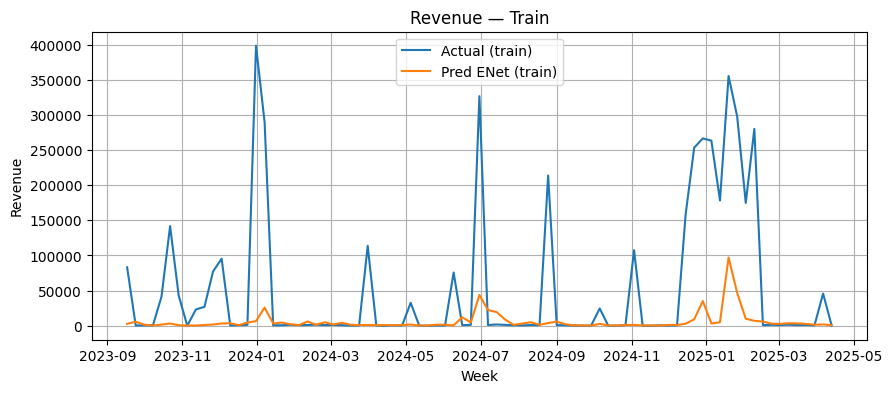

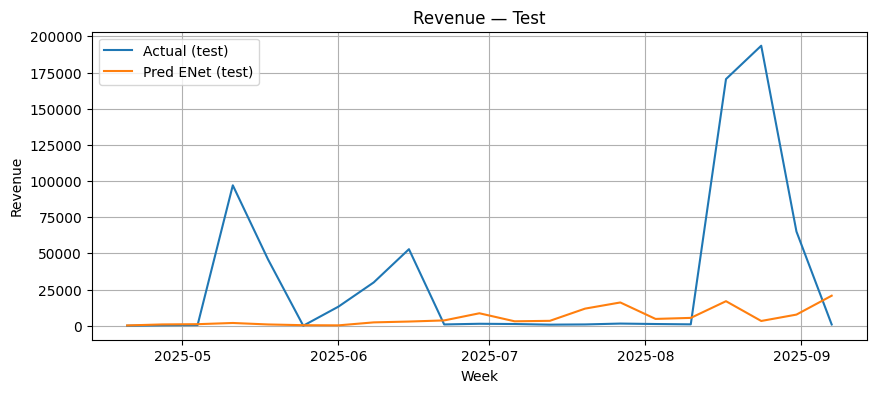

HGB — Train: R2=0.4428 | RMSE=74,446.17 | MAPE=284.69%
HGB — Test: R2=-0.1943 | RMSE=60,446.31 | MAPE=981.57%


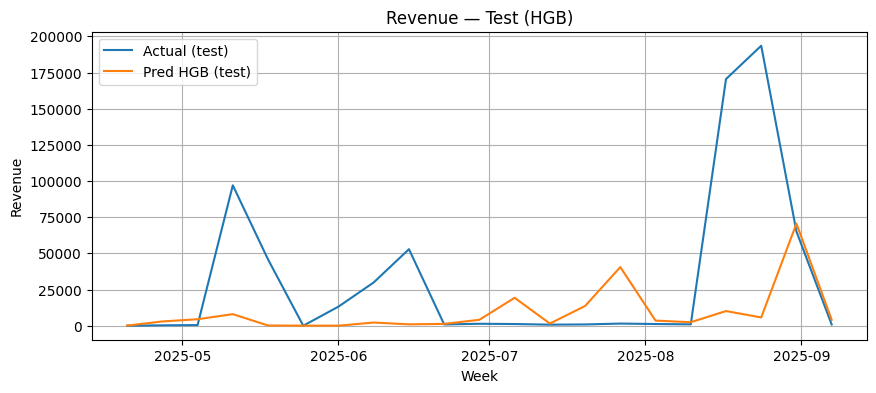

Chosen model for sensitivity: HGB
HGB is non-linear — skip coefficient table.


In [20]:
#@title 4) Stage-2: add AR lags, compare ElasticNet vs. Early-stop Gradient Boosting

from sklearn.ensemble import HistGradientBoostingRegressor

# --- make features: mediator + price/promo/CRM + seasonality + AR lags ---
def build_stage2_blocks(dd: pd.DataFrame, dates_block: pd.DataFrame):
    Xcore = pd.DataFrame({
        "log1p_avg_price": np.log1p(dd[price_col].fillna(0)),
        "log1p_g_hat":     np.log1p(dd["g_hat"].fillna(0)),
    })
    # AR lags on log1p revenue to tame spikes (no leakage: use shift)
    ylog = np.log1p(dd[target_col].clip(lower=1e-6))
    ar = pd.DataFrame({
        "y_log_lag1": ylog.shift(1),
        "y_log_lag2": ylog.shift(2),
    }).fillna(method="bfill")

    X = pd.concat([Xcore, dd[[promo_col]+controls].fillna(0), dates_block, ar], axis=1)
    return X

X2_full = build_stage2_blocks(df, X_dates_full)
y2_full = np.log1p(df[target_col].clip(lower=1e-6))

X2_tr, X2_te = X2_full.iloc[:split_ix], X2_full.iloc[split_ix:]
y2_tr, y2_te = y2_full.iloc[:split_ix], y2_full.iloc[split_ix:]

# --- Model A: ElasticNet (log target) ---
enet = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=np.logspace(-4,1,40),
                          cv=TimeSeriesSplit(n_splits=5),
                          max_iter=20000, random_state=42))
])
enet.fit(X2_tr, y2_tr)
pred_tr_en = np.expm1(enet.predict(X2_tr))
pred_te_en = np.expm1(enet.predict(X2_te))
act_tr = np.expm1(y2_tr); act_te = np.expm1(y2_te)
m_tr_en = print_metrics("ENet — Train", act_tr, pred_tr_en)
m_te_en = print_metrics("ENet — Test",  act_te, pred_te_en)

plt.figure(); plt.plot(df["week"].iloc[:split_ix], act_tr, label="Actual (train)")
plt.plot(df["week"].iloc[:split_ix], pred_tr_en, label="Pred ENet (train)")
plt.title("Revenue — Train"); plt.xlabel("Week"); plt.ylabel("Revenue"); plt.legend(); plt.show()

plt.figure(); plt.plot(df["week"].iloc[split_ix:], act_te, label="Actual (test)")
plt.plot(df["week"].iloc[split_ix:], pred_te_en, label="Pred ENet (test)")
plt.title("Revenue — Test"); plt.xlabel("Week"); plt.ylabel("Revenue"); plt.legend(); plt.show()

# --- Model B: Early-stopping Gradient Boosting (log target) ---
hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    max_iter=800,
    min_samples_leaf=12,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    scoring="neg_mean_squared_error"
)
hgb.fit(X2_tr, y2_tr)
pred_tr_gb = np.expm1(hgb.predict(X2_tr))
pred_te_gb = np.expm1(hgb.predict(X2_te))
m_tr_gb = print_metrics("HGB — Train", act_tr, pred_tr_gb)
m_te_gb = print_metrics("HGB — Test",  act_te, pred_te_gb)

plt.figure(); plt.plot(df["week"].iloc[split_ix:], act_te, label="Actual (test)")
plt.plot(df["week"].iloc[split_ix:], pred_te_gb, label="Pred HGB (test)")
plt.title("Revenue — Test (HGB)"); plt.xlabel("Week"); plt.ylabel("Revenue"); plt.legend(); plt.show()

# --- Choose best model for sensitivity
BEST_MODEL_NAME = "ENet" if m_te_en["RMSE"] <= m_te_gb["RMSE"] else "HGB"
BEST_MODEL = enet if BEST_MODEL_NAME == "ENet" else hgb
print("Chosen model for sensitivity:", BEST_MODEL_NAME)

# Coeffs table (only meaningful for ENet)
if BEST_MODEL_NAME == "ENet":
    coef = pd.Series(enet.named_steps["enet"].coef_, index=X2_tr.columns).sort_values(ascending=False)
    display(coef.to_frame("coef").style.set_caption("Stage-2 coefficients"))
else:
    print("HGB is non-linear — skip coefficient table.")

Stage-2 Boosting — Train: R2=1.0000 | RMSE=292.92 | MAPE=0.16%
Stage-2 Boosting — Test: R2=-0.3310 | RMSE=63,810.21 | MAPE=415.77%


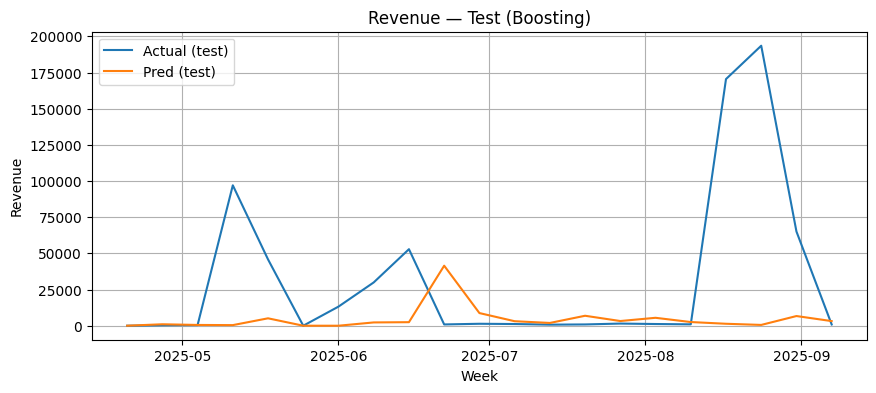

In [16]:
#@title 5) Optional: residualized social (direct effects) + gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Residualize adstocked social vs predicted mediator signal
Xad = pd.DataFrame({f"ad_{c}": adstock_geometric(df[c].fillna(0), lam_star) for c in social_cols})
gX = df["g_log1p_hat"].values.reshape(-1,1)
resid = {}
for col in Xad.columns:
    lr = LinearRegression().fit(gX, Xad[col].values)
    resid[col+"_resid"] = Xad[col].values - lr.predict(gX)
X_resid = pd.DataFrame(resid)

X2b_full = pd.concat([X2_full, X_resid], axis=1)
X2b_tr, X2b_te = X2b_full.iloc[:split_ix], X2b_full.iloc[split_ix:]

hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.05, max_iter=1000, min_samples_leaf=8, random_state=42
)
hgb.fit(X2b_tr, y2_tr)

pred_tr_b = np.expm1(hgb.predict(X2b_tr))
pred_te_b = np.expm1(hgb.predict(X2b_te))

print_metrics("Stage-2 Boosting — Train", act_tr, pred_tr_b)
print_metrics("Stage-2 Boosting — Test",  act_te, pred_te_b)

plt.figure(); plt.plot(df["week"].iloc[split_ix:], act_te, label="Actual (test)")
plt.plot(df["week"].iloc[split_ix:], pred_te_b, label="Pred (test)")
plt.title("Revenue — Test (Boosting)"); plt.xlabel("Week"); plt.ylabel("Revenue"); plt.legend(); plt.show()

,promotion,avg_price,pred_revenue
0,0,84.28500,83448.874460
1,0,86.62625,83448.874460
2,0,88.96750,83448.874460
3,0,91.30875,83448.874460
4,0,93.65000,27081.270685
5,0,95.99125,27767.972786
6,0,98.33250,35987.657105
7,0,100.67375,35987.657105
8,0,103.01500,35987.657105
9,1,84.28500,83448.874460


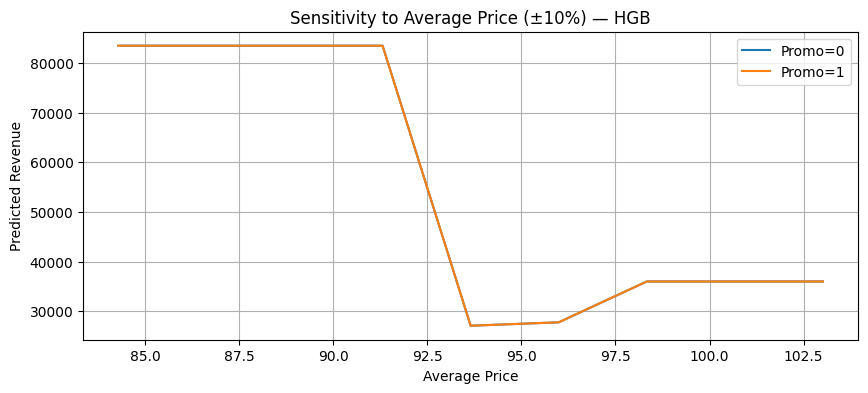

In [21]:
#@title 6) Sensitivity: ±10% price with/without promotion (using chosen model)

FEATURE_COLS = list(X2_full.columns)

def make_stage2_features_any(dd: pd.DataFrame) -> pd.DataFrame:
    dates = DateFeatures("week").transform(dd).reset_index(drop=True)
    ylog = np.log1p(dd[target_col].clip(lower=1e-6))
    ar   = pd.DataFrame({
        "y_log_lag1": ylog.shift(1),
        "y_log_lag2": ylog.shift(2),
    }).fillna(method="bfill").reset_index(drop=True)

    Xcore = pd.DataFrame({
        "log1p_avg_price": np.log1p(dd[price_col].fillna(0).values),
        "log1p_g_hat":     np.log1p(dd["g_hat"].fillna(0).values),
    })
    Xblk = pd.concat([
        Xcore.reset_index(drop=True),
        dd[[promo_col]+controls].fillna(0).reset_index(drop=True),
        dates, ar
    ], axis=1)

    for c in FEATURE_COLS:
        if c not in Xblk.columns:
            Xblk[c] = 0.0
    return Xblk[FEATURE_COLS].fillna(0)

def predict_rev(model, X):
    # both ENet and HGB were trained on log1p(y)
    return float(np.expm1(model.predict(X))[0])

last = df.iloc[[-1]].copy()
grid = np.linspace(0.9*last[price_col].item(), 1.1*last[price_col].item(), 9)

rows = []
for promo in [0,1]:
    for p in grid:
        tmp = last.copy()
        tmp[price_col] = p
        tmp[promo_col] = promo
        tmp["g_hat"]   = last["g_hat"].values  # hold media fixed
        Xtmp = make_stage2_features_any(tmp)
        yhat = predict_rev(BEST_MODEL, Xtmp)
        rows.append({"promotion": promo, "avg_price": float(p), "pred_revenue": yhat})

sens = pd.DataFrame(rows)
display(sens)

for promo in [0,1]:
    sub = sens[sens["promotion"]==promo]
    plt.plot(sub["avg_price"], sub["pred_revenue"], label=f"Promo={promo}")
plt.title(f"Sensitivity to Average Price (±10%) — {BEST_MODEL_NAME}")
plt.xlabel("Average Price"); plt.ylabel("Predicted Revenue"); plt.legend(); plt.show()

In [22]:
#@title 7) Save artifacts & summary

import pathlib, json
out = pathlib.Path("out"); out.mkdir(exist_ok=True)

# Metrics JSON
with open(out / "metrics_elasticnet.json", "w") as f:
    json.dump({"train": m_tr, "test": m_te,
               "lambda_star": lam_star,
               "oof_r2_mediator": round(float(best["oof_r2"]), 4)}, f, indent=2)

# Predictions CSV (train+test)
pred_df = pd.DataFrame({
    "week": df["week"],
    "actual_revenue": df[target_col],
    "pred_revenue_enet": np.r_[pred_tr, pred_te],
    "g_hat": df["g_hat"],
    "average_price": df[price_col],
    "promotions": df[promo_col]
})
pred_df.to_csv(out / "predictions_enet.csv", index=False)

# Coefs CSV
coef.to_csv(out / "stage2_enet_coefs.csv", header=["coef"])

print("Saved to ./out →",
      "metrics_elasticnet.json, predictions_enet.csv, stage2_enet_coefs.csv")

# Short run summary (easy for reviewers)
print("\n=== RUN SUMMARY ===")
print(f"HOLDOUT_PCT: {HOLDOUT_PCT} | Train rows: {split_ix} | Test rows: {len(df)-split_ix}")
print(f"Stage-1 mediator: best λ={lam_star} | OOF R²={best['oof_r2']:.3f}")
print(f"Stage-2 ElasticNet Test: R2={m_te['R2']:.3f}, RMSE={m_te['RMSE']:,.0f}, MAPE={m_te['MAPE_%']:.2f}%")

Saved to ./out → metrics_elasticnet.json, predictions_enet.csv, stage2_enet_coefs.csv

=== RUN SUMMARY ===
HOLDOUT_PCT: 0.2 | Train rows: 83 | Test rows: 21
Stage-1 mediator: best λ=0.9 | OOF R²=-0.103
Stage-2 ElasticNet Test: R2=-0.236, RMSE=61,492, MAPE=2830.02%
